# Spatial Representation Efficiency and Accuracy in ConvNets
It has been claimed that naive implementations of convolutional networks are inappropriate for computing spatial transformations - particularly where the network is expected to compute the spatial position of a feature within an image (Liu et al, 2016). Liu et al proposed a new architectural component, the CoordConv layer, with the goal of explicitly supporting the capture and encoding of spatial information.

I appear to have run into such problems in my own experiments on a larger problem of image alignment, however I have also found that simple convolutional networks can indeed encode spatial information without explicit architecture. This conclusion is further supported by the wide range of networks that directly compute spatial information such as image alignment (DeTone et al, 2016), and bounding boxes (Redmond et al, 2016) without explicit architectural components such as CoordConv.

I suspect that different architectures vary not in a strict binary sense of whether or not they can encode and transform spatial information, but rather in how efficient they are in computing and encoding that spatial information, and consequently in how accurate their final outputs are for a given computational capacity. This notebook examines a few architectures and tries to directly measure and contraist their informational encoding efficiency.

The notebook is broken into a few sections:
* Helper code - various functions, custom layers, and plotting tooling that we'll use throughout.
* Architectures - each architecture is described, a theory proposed, and then results measured.
* Summary - results from each architecture are compared.

### See Also
... link to "custom-layers-and-loss" notebook.

Initial results and experiments were carried out within the following notebooks:
* https://github.com/malcolmlett/robovac/blob/main/experiments-slam/Experiment_ADLO_3a_SpatialAccuracy.ipynb
* https://github.com/malcolmlett/robovac/blob/main/experiments-slam/Experiment_ADLO_3b_SpatialLayerTesting.ipynb
* https://github.com/malcolmlett/robovac/blob/main/experiments-slam/Experiment_ADLO_3c_Hypertuning.ipynb


### References
* DeTone, D., Malisiewicz, T., Rabinovich, A (2016). Deep image homography estimation. ArXiv. https://arxiv.org/abs/1606.03798

* Liu, R., Lehman, J., Molino, P., et al (2016). An Intriguing Failing of Convolutional Neural Networks and the CoordConv Solution. NeurIPS 2018.
https://arxiv.org/abs/1807.03247v2

* Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2016). You Only Look Once: Unified, Real-Time Object Detection. ArXiv. https://arxiv.org/abs/1506.02640



In [37]:
# Install Training Instrumentation Toolkit
# (locked to specific git revision so this notebook always works)
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
  !cd training-instrumentation-toolkit && git checkout 550ac65
sys.path.append('training-instrumentation-toolkit')

# Install repo just for this notebook
# (optionally locked to specific git revision so this notebook always works)
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo
sys.path.append('repo/doc/blog-202506')
#!cd repo && git checkout be28234
!cd repo && git pull

# Load custom libraries
from importlib import reload
import blog_code as blog
import train_instrumentation as tinstr
reload(blog)

# Load standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import tensorflow as tf
from tensorflow.keras import layers
import IPython.display as idisplay
import time
import os
import sys
import math
import tqdm
import cv2
import re

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")

HEAD is now at cb18c0c Bug fixes
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 11 (delta 8), reused 9 (delta 6), pack-reused 0 (from 0)
Unpacking objects: 100% (11/11), 322.41 KiB | 875.00 KiB/s, done.
From https://github.com/malcolmlett/robovac
   cb18c0c..2534962  main       -> origin/main
Updating cb18c0c..2534962
Fast-forward
 doc/blog-202506/blog_code.py                   | 181 +++++++
 doc/blog-202506/blog_code_test.py              |  33 ++
 doc/blog-202506/custom_layers_and_losses.ipynb | 704 ++++++++++++++++++++++---
 3 files changed, 844 insertions(+), 74 deletions(-)
TensorFlow version: 2.18.0
Keras version: 3.8.0
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [38]:
# run unit tests
import blog_code_test
reload(blog)
reload(blog_code_test)

blog_code_test.run_test_suite()

test_AttentionPool2D (blog_code_test.CustomLayers.test_AttentionPool2D) ... ok
test_CoordGrid (blog_code_test.CustomLayers.test_CoordGrid) ... ok
test_HeatmapPeakCoord (blog_code_test.CustomLayers.test_HeatmapPeakCoord) ... ok
test_PositionwiseMaxPool2D (blog_code_test.CustomLayers.test_PositionwiseMaxPool2D) ... ok
test_MeanCoordError (blog_code_test.CustomMetrics.test_MeanCoordError) ... /usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
ok
test_MeanCoordError (blog_code_test.CustomMetricsAndLosses.test_MeanCoordError) ... /usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
ok
test_heatmap_coordinates_roundtrip (blog_code_test.DataGeneration.test_heatmap_coordinates_roundt

## Dataset
The dataset is a set of black images with the top-left corner of a thick-edged frame appearing somewhere within the main area of the image (avoiding the area near the edge for simplicity). The images have a low-density white-spot noise. The task of the model is to identify the location of the frame corner.

### Image Format
For completely arbitrary reasons, I'm using images of size `149x149x1` (grayscale), and coordinates are represented as a fraction of image width, relative to the image centre. ie: x, y both in range `-0.5 .. +0.5`.

Image centre is always exactly at `149 // 2 = 74`.

Where it matters, the integer coordinate of a pixel is considered to identify the centre of the pixel.

### Model Outputs
As we'll be working with models of different architectures, we'll also be working with two different output formats:

1. The `(x,y)` coordinate of frame corner (in range `-0.5 .. +0.5`)
2. A heatmap of size `149x149x1` where the 3x3 grid surrounding the max value are used to represent the coordinate of the frame corner.

In the latter case, the values of the peak 3x3 grid are used as a weighted sum of the coordinates of the pixels in that grid, producing a single `(x,y)` coordinate with sub-pixel precision.

### Dataset Format
In order to support the different model architectures, the core dataset is made up of tuples: `(input_image, true-xy-coord, true-heatmap)`.

### Examples
Let's take a look.

An image is created like as follows:

image shape: (149, 149, 1), val range: 0.0 .. 1.0


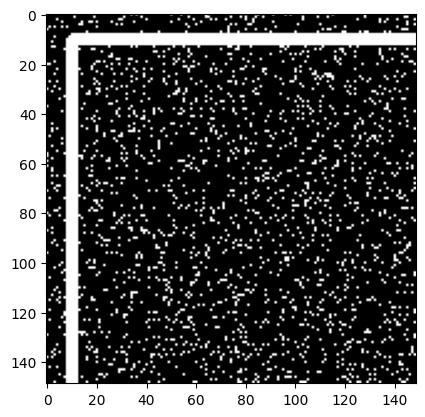

In [6]:
im = blog.generate_training_image(10,10)
print(f"image shape: {np.shape(im)}, val range: {np.min(im)} .. {np.max(im)}")
plt.imshow(im, cmap='gray')
plt.show()

For models that generate heatmap outputs, a ground-truth heatmap looks like as follows. Additionally, we can use the `weighted_peak_coordinates()` function to extract the coordinates.

generated heatmap image: shape=(149, 149, 1), val range: 0.0 .. 0.25
inferred coordinate: [[-0.4295302 -0.4295302]], as pixels: [[10. 10.]]


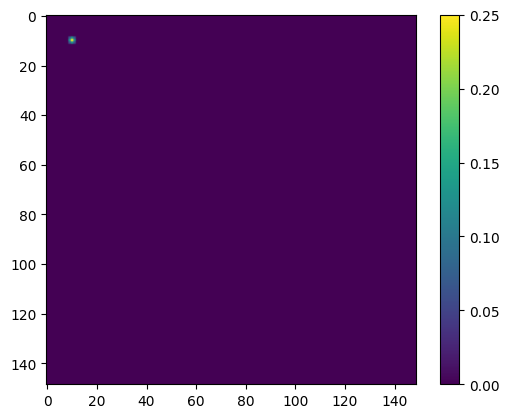

In [9]:
im = blog.generate_heatmap_image(10,10)
coord = blog.weighted_peak_coordinates(tf.reshape(im, (1, 149, 149, 1)))
print(f"generated heatmap image: shape={np.shape(im)}, val range: {np.min(im)} .. {np.max(im)}")
print(f"inferred coordinate: {coord[0]}, as pixels: {coord[0] * 149 + 149//2}")

plt.imshow(im)
plt.colorbar()
plt.show()

**Fixed dataset**

Now create a one-off dataset and show how good the heatmap can be used to accurately calculate the ground-truth coordinates.

In the figure below, each dataset sample has two images:
* Input image + ground-truth coordinate (blue circle)
* Ground-truth heatmap + ground-truth coordinate (blue circle) + coordinate predicted from heatmap (red circle)

This figure is based entirely on the training data, without model predictions. When the model is provided to the plot_dataset() function it'll show the model predictions.

100%|██████████| 100/100 [00:00<00:00, 601.40it/s]


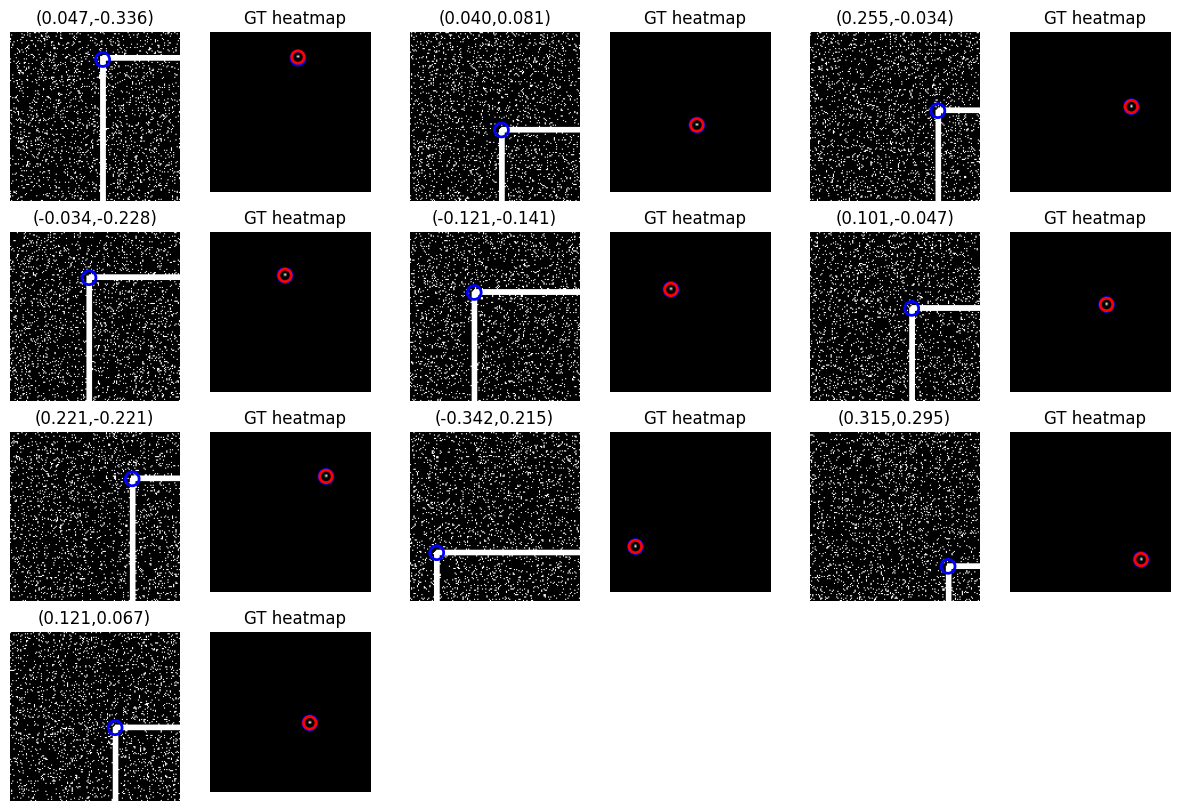

In [21]:
# create training and validation data
train_data = blog.create_dataset(1000)
val_data = blog.create_dataset(100)

# Plot some of the training dataset
#plot_dataset(train_data)
blog.plot_dataset(train_data, show_heatmap=True)

## Custom Layers

We're using a number of custom layers in the models. For details see the following notebook:
* https://github.com/malcolmlett/robovac/blob/main/doc/blog-202506/custom_layers_and_losses.ipynb

In brief, those layers are:
* HeatmapPeakCoord
  * wraps a call to weighted_peak_coordinates() so that a model can produce a heatmap in its second to last layer, and then use this layer to finally output the coordinate.
* CoordGrid2
  * Returns a (batch_size, height, width, 2) tensor with a grid of (x,y) coordinates.
* StrideGrid2D
  * Like CoordGrid2 but coordinates are relative to their "stride-patches". Intended as input to a strided pooling layer.
* PositionwiseMaxPool2D
  * Inspired by max-pool, however, where max-pool treats each channel separately, this groups all features together for a given 2D position. This in theory allows for more direct transport of spatial information from a CoordGrid2D or StrideGrid2D input.
* AttentionPool2D
  * An alternative to MaxPool2D that tries to improve on gradient flow by using a soft-argmax operation.
* StridedSoftmax2D
  * Applies softmax to values within stride-patches. The first part of AttentionPool2D broken out as a separate layer, for easier visibility.
* DotPool2D
  * 2D downsampling layer that combines the values between two inputs via a flattened dot-product applied patch-wise and channel-wise. The second part of AttentionPool2D broken out as a separate layer, for easier visibility.



## Models
Now we'll get onto the models themselves.

### Simple ConvNet Regression

This is a vanilla regression ConvNet that makes no attempt at customising to support spatial information. Based loosely on AlexNet, it is made up of a collection of blocks with Conv2D and MaxPool2D. Each block reduces the resolution by half until it reaches a 1x1 resolution, which is then followed up by a fully connected layer to reach the desired `(2,)` vector output.

According to Liu et al (2018) we would expect such a network to fail _spectacularly_. However, as you will see, this is not the case.

Surprisingly, the pure ConvNet architecture is able to identify the single corner location to within 1 to 3px. So it's possible for an unmodified CNN to convey spatial information. The question is how?

The following offers one possible explanation...

**2x2 One-hot Encoding**

Take a single 2x2 patch that will become 1x1 following maxpool. One theory is that it can use 4 channels to encode the same feature, but at each of the 4 offsets. In other words, each of 4 channels will learn to detect the same feature, but they'll be learned in such a way that they'll detect that feature in slightly different positions relative to the given pixel position.

Imagine now that you have the actual feature at an actual position. Across the 4 channels on some position, only one will have the best match. Max-pool will convert the 2x2x4 patch into 1x1x4, with the channel with the highest value indicating its corresponding source position as the location of the feature. In other words, _one-hot encoding_.

In order to retain full accuracy in the next block, it will take another 2x2 grid of 4 channels, but multiplied by the 4-channel input, giving 16 channels in the new one-hot encoding. Or, put another way, the next block's maxpool output has 4x4=16 possible sources, so needs to encode with 16 channels for one-hot encoding.

Thus, in theory, a network with blocks of the form (1conv + 1maxpool), with stride $s$, require an exponential increase in the number of channels ($c$) at each block ($b \in 1,..,B$), as follows:
$$
c = s^{2b}
$$

If there's less than that, then the accuracy will be _clipped_. For example, if we restrict to 16 channels throughout, then the final block will only identify the grid-cell in the second-to-last block, without identifying where in that grid-cell.

By way of example, let's consider the model below, but assume a single conv layer per block (see below for workings):
* $s = 2, b = 7$
* $c = 2^{14}$ = 16,384 channels
* However, our 1x1 conv layer has only 128 channels in its default instantiation. In theory this should yield an accuracy of no batter than 13.2 pixels.

**2x2 One-hot Encoding with Compression**

For the more common conv network with multiple conv layers per block, it may be able to compress the encoding. For example, a 4-channel one-hot encoding can be easily compressed into a single channel having values in 4 ranges. You convert the one-hot encoding to so-called "sparse encoding" (ie: argmax) and divide by 4.

There's a few ways for ReLU conv layers to achieve this. One is by thresholding at the one-hot encoding layer (with the hope of having only a single channel still non-zero), multiplying by different weights and summing. Another is to acknowledge that the channels are probably already fairly well globally normalised because the same weights are used at all positions, and because backprop could induce that outcome if the loss surface implies it. And also to acknowledge that in this simple experiment, non-matches are probably very close to zero. At that point, you can simply assume they're close enough to perfectly 0.0 or 1.0, and then just sum them with different weights. For example, if the channels are a, b, c, d, then the equivalent 1-channel encoding is produced via:
$$
  \text{value} = 1a + 2b + 3c + 4d
$$

That can be done via just the weights in a single conv layer, leaving the activation function available for part of any other processing.

Conceivably, this architecture could retain high spatial accuracy with only a small small number of channels.


In [12]:
def calculate_onehotencoding_theory(strides, blocks, max_channels):
  """
  Assumes one-hot-encoding theroy and no representational compression.
  Using s^(2b) to calculate required number of channels for perfect resolution.
  """
  s=strides
  b=blocks
  f=max_channels
  eff_b=math.log(f)/math.log(s)/2
  eff_res=149/(2**eff_b)
  print(f"Assuming one-hot-encoding theory and no representational compression:")
  print(f"  Required channels in last block for perfect resolution:  {s**(2*b):,}")
  print(f"  Effective resolution at {f} channels (in blocks):        {eff_b}")
  print(f"  Effective resolution at {f} channels (in pixels):        {eff_res}")
calculate_onehotencoding_theory(strides=2, blocks=7, max_channels=128)

Assuming one-hot-encoding theory and no representational compression:
  Required channels in last block for perfect resolution:  16,384
  Effective resolution at 128 channels (in blocks):        3.5
  Effective resolution at 128 channels (in pixels):        13.169863799599447


In [53]:
def convnet_model(min_filters=4, max_filters=4096, conv_per_block=2, batch_norm=False, dropout=None):
  def downscale(filters, x):
    for _ in range(conv_per_block):
      x = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    if batch_norm:
      x = layers.BatchNormalization()(x)
    if dropout is not None:
      x = layers.Dropout(dropout)(x)
    return x

  input = tf.keras.Input(shape=(149, 149, 1))
  x = input

  # AlexNet-like downsampling leg: 149x149x1 -> 1x1x2
  # (per-block shapes assume default hypeparameters)
  filters = min_filters
  x = downscale(min(filters*1, max_filters), x)  # 74x74x4
  x = downscale(min(filters*2, max_filters), x)  # 37x37x8
  x = downscale(min(filters*4, max_filters), x)  # 18x18x16
  x = downscale(min(filters*8, max_filters), x)  # 9x9x32
  x = downscale(min(filters*16, max_filters), x) # 4x4x64
  x = downscale(min(filters*32, max_filters), x) # 2x2x128
  x = downscale(min(filters*32, max_filters), x) # 1x1x128

  # Output leg
  x = layers.Flatten()(x)
  x = layers.Dense(2, kernel_initializer='normal')(x)

  return tf.keras.Model(inputs=input, outputs=x)

convnet_model(conv_per_block=2).summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 149, 149, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 149, 149, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 149, 149, 4)    │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 74, 74, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 74, 74, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 74, 74, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 37, 37, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 37, 37, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 37, 37, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 18, 18, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,734 (2.25 MB)

 Trainable params: 590,734 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
dataset = train_data.map(blog.to_coordinate_dataset).prefetch(True).batch(32)
val_dataset = val_data.map(blog.to_coordinate_dataset).prefetch(True).batch(32)
model = convnet_model(conv_per_block=2)
model.compile(optimizer='adam', loss='mse', metrics=[blog.MeanCoordError(name='mpe', encoding='xy', system='pixels')])  # mean-pixel-error
history = model.fit(dataset, epochs=50, verbose=0, validation_data=val_dataset, callbacks=[tinstr.LessVerboseProgressLogger()])

Epoch     5 - 3.14s/epoch: loss: 0.0006  mpe: 4.5390  val_loss: 0.0009  val_mpe: 5.1712  
Epoch    10 - 499.94ms/epoch: loss: 0.0004  mpe: 3.5415  val_loss: 0.0007  val_mpe: 4.7199  
Epoch    15 - 563.60ms/epoch: loss: 0.0004  mpe: 3.7212  val_loss: 0.0006  val_mpe: 4.0566  
Epoch    20 - 498.90ms/epoch: loss: 0.0005  mpe: 3.9306  val_loss: 0.0012  val_mpe: 6.4217  
Epoch    25 - 432.79ms/epoch: loss: 0.0002  mpe: 2.8893  val_loss: 0.0006  val_mpe: 4.4552  
Epoch    30 - 438.95ms/epoch: loss: 0.0006  mpe: 4.4539  val_loss: 0.0007  val_mpe: 4.5312  
Epoch    35 - 407.31ms/epoch: loss: 0.0003  mpe: 3.5485  val_loss: 0.0006  val_mpe: 4.3060  
Epoch    40 - 487.87ms/epoch: loss: 0.0002  mpe: 2.5581  val_loss: 0.0008  val_mpe: 5.0098  
Epoch    45 - 503.99ms/epoch: loss: 0.0012  mpe: 6.4325  val_loss: 0.0018  val_mpe: 7.8397  
Epoch    50 - 434.00ms/epoch: loss: 0.0002  mpe: 2.6175  val_loss: 0.0002  val_mpe: 2.6566  
Total training time: 37.0 sec


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


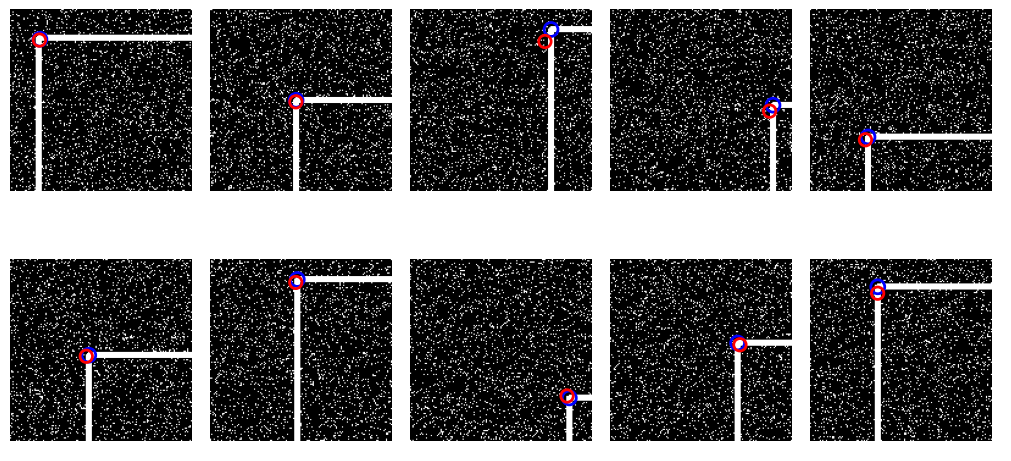

In [48]:
blog.plot_dataset(val_data, model)

**With only 1 conv layer per block**

In [50]:
dataset = train_data.map(blog.to_coordinate_dataset).prefetch(True).batch(32)
val_dataset = val_data.map(blog.to_coordinate_dataset).prefetch(True).batch(32)
model = convnet_model(conv_per_block=1)
model.compile(optimizer='adam', loss='mse', metrics=[blog.MeanCoordError(name='mpe', encoding='xy', system='pixels')])  # mean-pixel-error
history = model.fit(dataset, epochs=50, verbose=0, validation_data=val_dataset, callbacks=[tinstr.LessVerboseProgressLogger()])

Epoch     5 - 1.70s/epoch: loss: 0.0082  mpe: 16.2429  val_loss: 0.0068  val_mpe: 14.5147  
Epoch    10 - 267.94ms/epoch: loss: 0.0016  mpe: 7.4417  val_loss: 0.0025  val_mpe: 9.2533  
Epoch    15 - 263.52ms/epoch: loss: 0.0006  mpe: 4.3105  val_loss: 0.0029  val_mpe: 10.2463  
Epoch    20 - 268.16ms/epoch: loss: 0.0010  mpe: 5.9057  val_loss: 0.0018  val_mpe: 7.8361  
Epoch    25 - 228.10ms/epoch: loss: 0.0003  mpe: 3.2857  val_loss: 0.0022  val_mpe: 9.0593  
Epoch    30 - 263.26ms/epoch: loss: 0.0009  mpe: 5.7463  val_loss: 0.0034  val_mpe: 11.1862  
Epoch    35 - 280.13ms/epoch: loss: 0.0015  mpe: 7.3154  val_loss: 0.0029  val_mpe: 10.0670  
Epoch    40 - 239.83ms/epoch: loss: 0.0007  mpe: 4.7476  val_loss: 0.0019  val_mpe: 7.7885  
Epoch    45 - 294.49ms/epoch: loss: 0.0002  mpe: 2.4882  val_loss: 0.0011  val_mpe: 6.1307  
Epoch    50 - 480.40ms/epoch: loss: 0.0001  mpe: 2.2765  val_loss: 0.0011  val_mpe: 5.9130  
Total training time: 21.4 sec


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


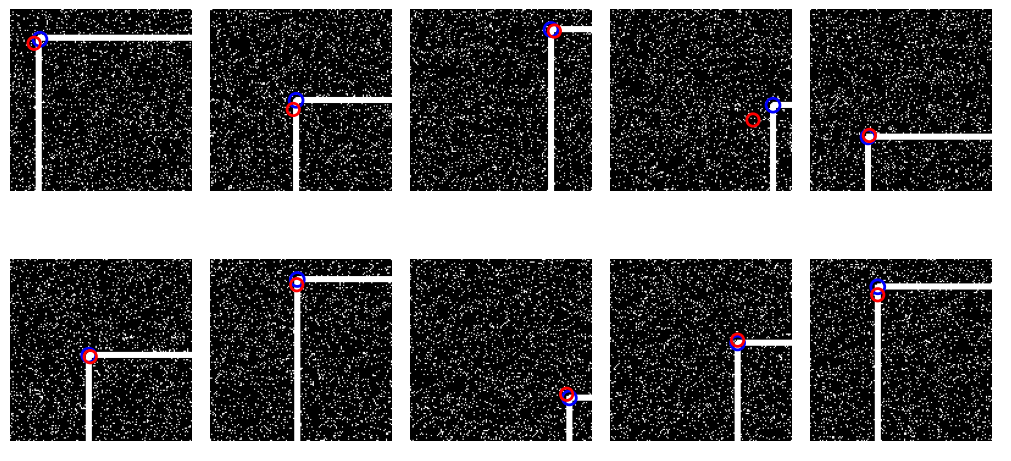

In [51]:
blog.plot_dataset(val_data, model)